# Sea surface height standard deviation

In [6]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc
from collections import OrderedDict
import pandas as pd

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)

def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']

loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'

fs = 15

alpha_res = 2.
p_res = 50

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 12

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012',walltime='04:00:00')
    cluster.scale(nw)
    client = Client(cluster)

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/33249/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/33249/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:36915,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/33249/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Compute the standard deviation

In [8]:
%%time 
from scipy.signal import detrend

ssh_stds = []
res_funcs = []
for i in range(num_sims):
    sim = sims[i]
    
    sim.open_all_files(sim.native_path,preprocess=lambda ds: ds[['SSH','Rd_dx']])
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))    
    sim.open_grid()

    Rd_dx = sim.ds.Rd_dx.mean('time').compute()
    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)
    
    ## Remove the mean
    SSH_mean = sim.ds.SSH.mean(dim='time')
    SSH_anom = sim.ds.SSH - SSH_mean
    
    # Remove seasonal cycle
    SSH_seasonal_cycle = SSH_anom.groupby('time.month').mean(dim='time')
    SSH_no_season = SSH_anom.groupby('time.month') - SSH_seasonal_cycle
    
    ## Remove linear trend
    mask_value = -9999  
    masked_SSH_no_season =  SSH_no_season.where(~np.isnan(SSH_no_season), mask_value)
    masked_SSH_no_season = masked_SSH_no_season.load()
    masked_SSH_no_trend = xr.apply_ufunc(detrend, masked_SSH_no_season, kwargs={'axis': 0})
    SSH_no_trend = masked_SSH_no_trend.where(masked_SSH_no_season != mask_value)
    
    
    ssh2 = SSH_no_trend**2
    ssh2 = ssh2.mean('time')
    ssh = SSH_no_trend.mean('time')
    ssh_std = np.sqrt(ssh2-ssh**2)  
    ssh_stds.append(ssh_std)

Opened all files
Opened grid and assigned coordinates.


/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


Opened all files
Opened grid and assigned coordinates.


/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


Opened all files
Opened grid and assigned coordinates.


/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


Opened all files
Opened grid and assigned coordinates.


/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


CPU times: user 52.8 s, sys: 2min 57s, total: 3min 50s
Wall time: 10min 2s


### Plot the standard deviation

In [9]:
save_path = 'png/'

aviso_path = '/glade/campaign/cgd/oce/datasets/cesm/tx1_4/ssh/ssh_std_aviso_to_tx1_4.nc'
obs = xr.open_dataset(aviso_path)
obs  = obs.assign_coords({'geolon': sims[0].grid['geolon'], 'geolat': sims[0].grid['geolat']})
obs_std = obs.ssh_std

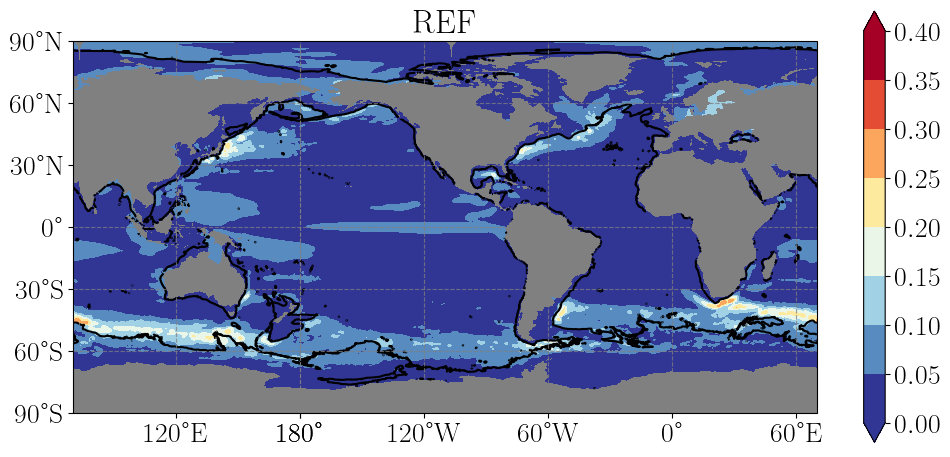

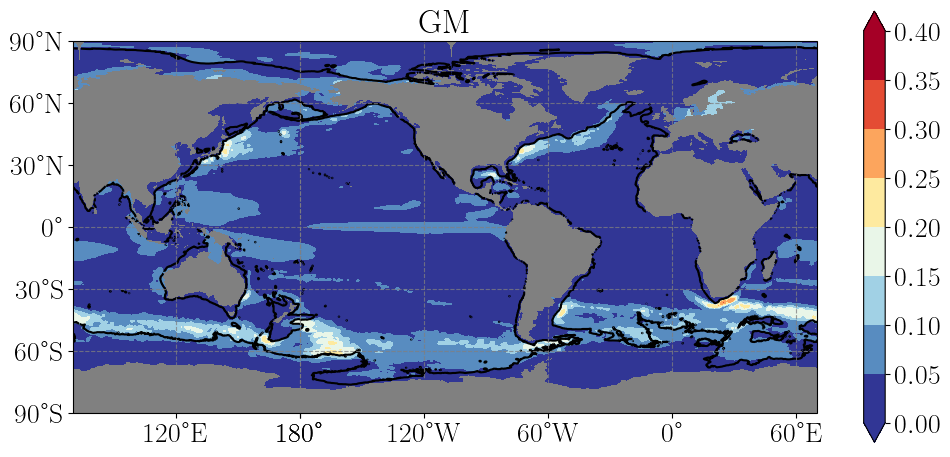

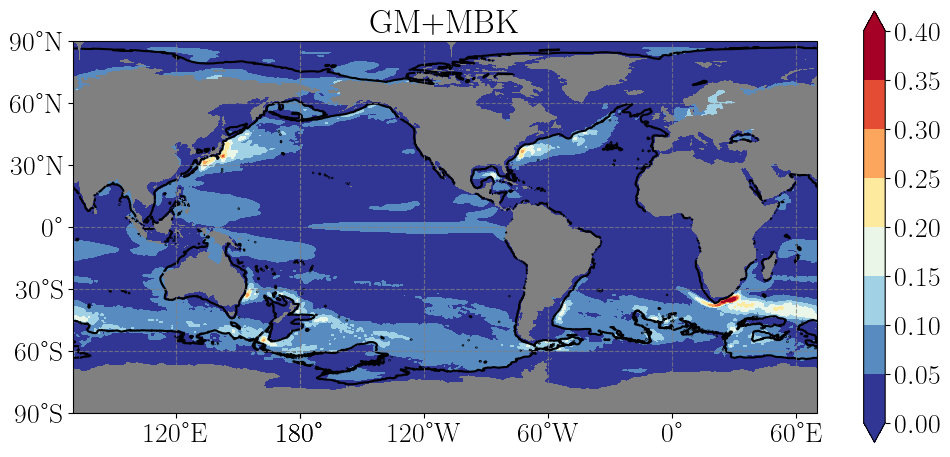

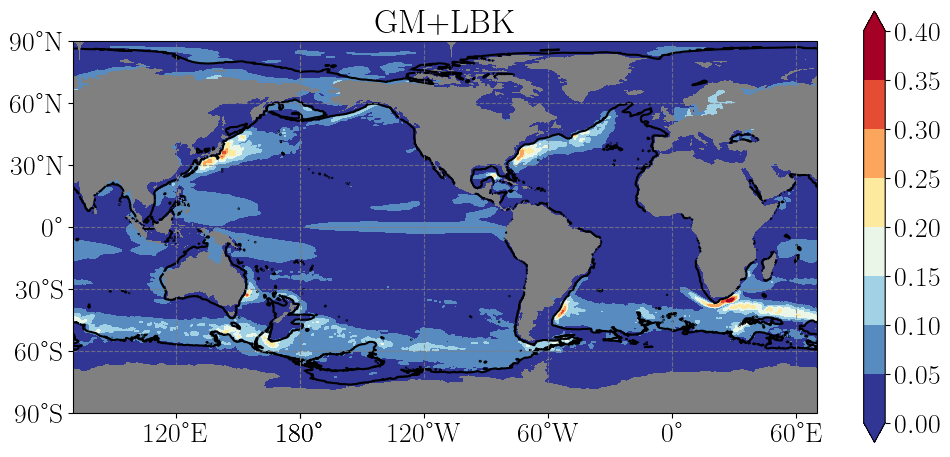

In [16]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 0.4
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)
snames = ['REF','GM','GM+MBK','GM+LBK']

for sim, sname, R, ssh_std in zip(sims, snames, res_funcs, ssh_stds):
    title = sname
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(ssh_std,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+"SSH_STD"+title+'.png',dpi=300)

### Differences with reference simulation

In [19]:
diffs = []
for i in range(1,num_sims):
    diff = ssh_stds[i].fillna(0)-ssh_stds[0].fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    diffs.append(diff)

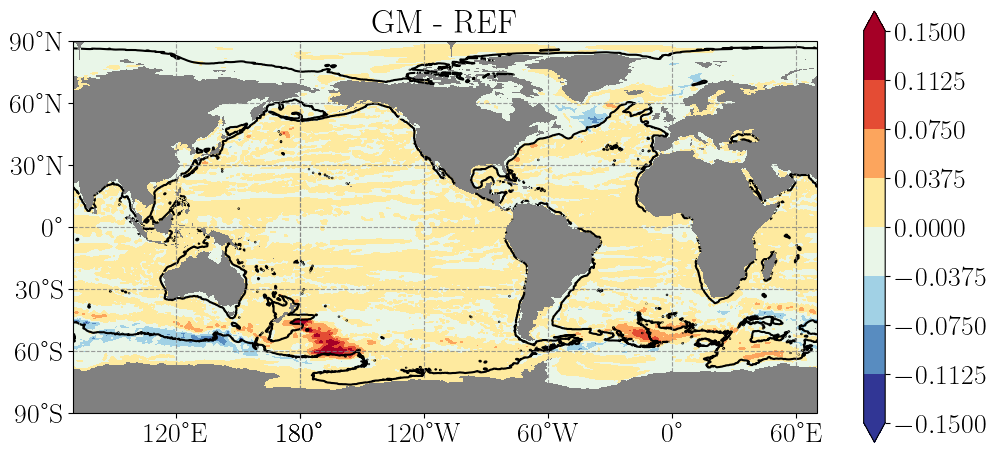

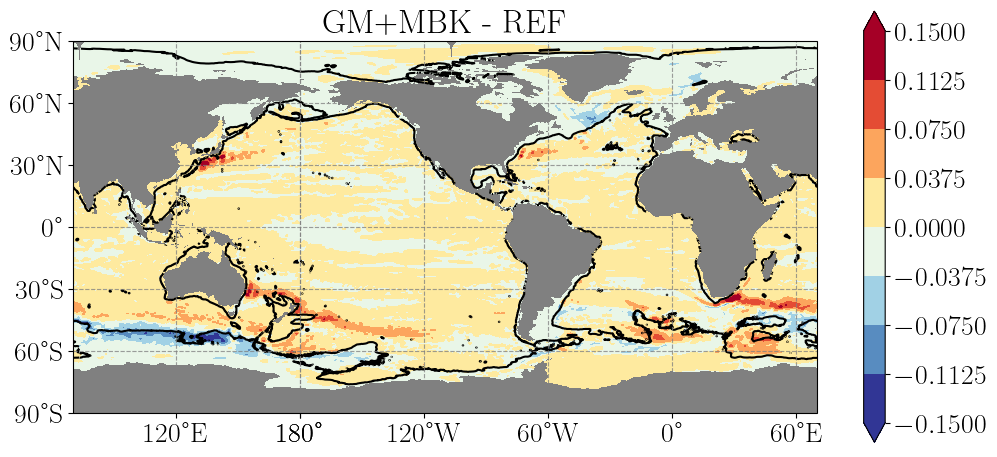

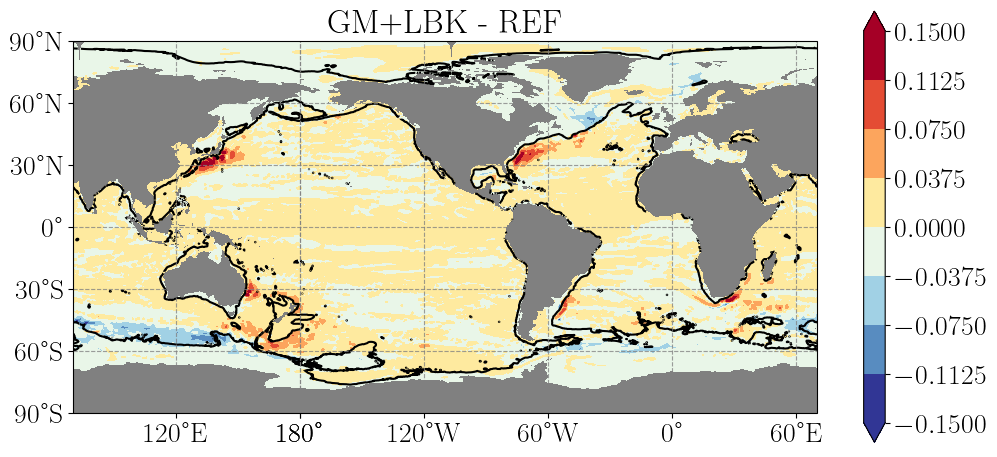

In [20]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -0.15, 0.15
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, diff in zip(sims[1:], res_funcs[1:], diffs):
    title = sim.short_name + " - REF"
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

    plt.savefig(save_path+"SSH_STD"+title+'.png',dpi=300)

### Differences with observations

In [25]:
grid = sims[0].grid
obs_path = '/glade/work/gmarques/cesm/tx1_4/ssh/'
obs_std = xr.open_dataset(obs_path+'ssh_std_aviso_to_tx1_4.nc', decode_times=False)
obs_std = obs_std.rename({'ny': 'yh','nx':'xh'})
obs_std = obs_std.assign_coords({'geolon': grid['geolon'],
                          'geolat': grid['geolat']})
obs_std = obs_std.ssh_std

In [26]:
diffs_obs = []
for i in range(num_sims):
    diff = ssh_stds[i].fillna(0)-obs_std.fillna(0)
    diff = diff.assign_coords({'geolon': sims[0].grid['geolon'],'geolat': sims[0].grid['geolat']})
    diff = diff.where(diff != 0, np.nan)

    diffs_obs.append(diff)

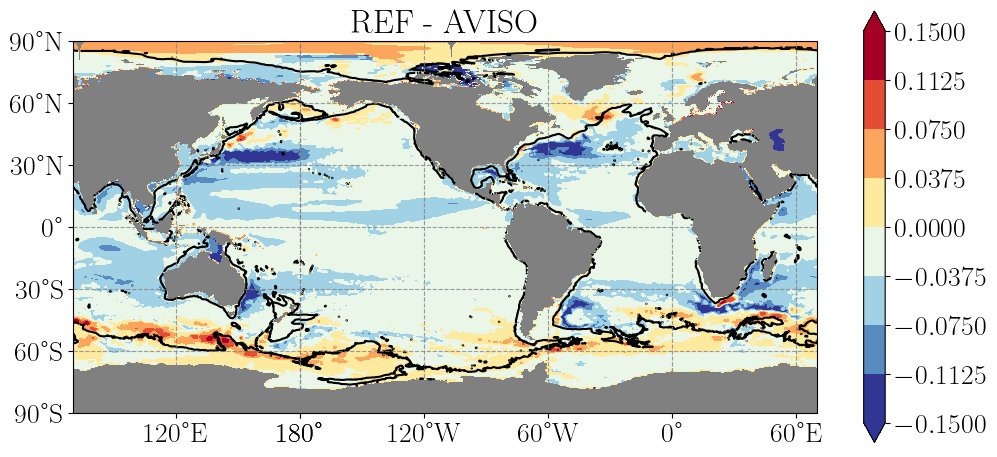

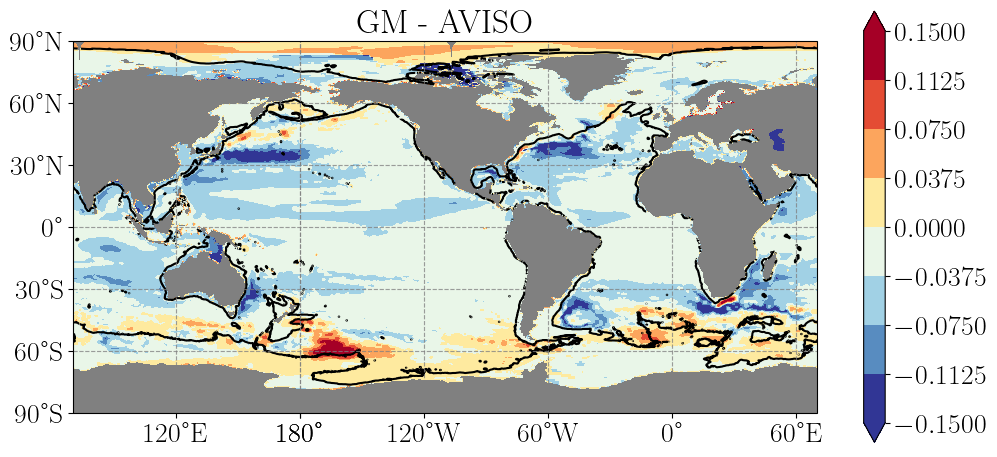

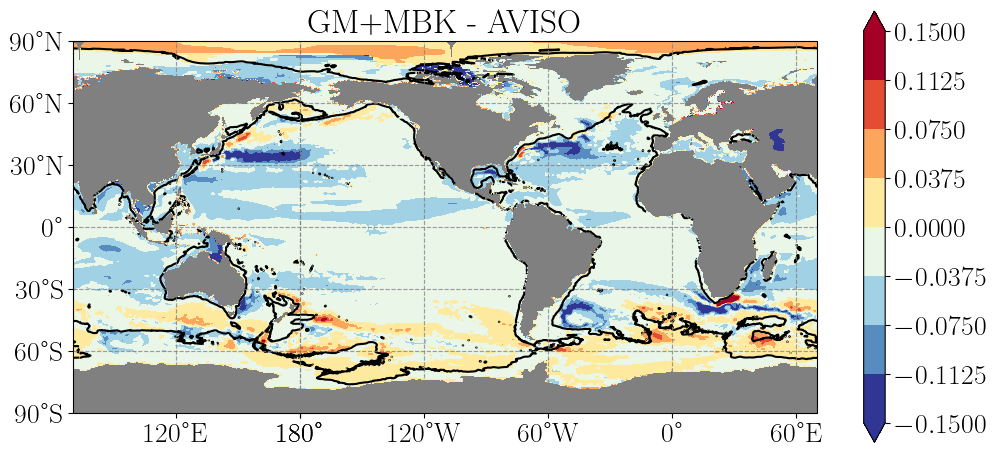

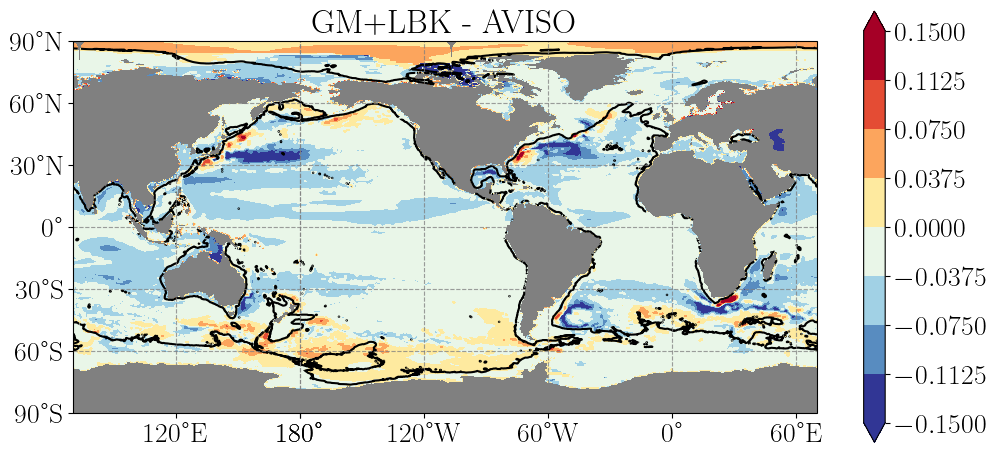

In [28]:
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = -0.15, 0.15
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]
snames = ['REF','GM','GM+MBK','GM+LBK']

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, sname, R, diff in zip(sims, snames, res_funcs, diffs_obs):
    title = sname + " - AVISO"
    # pass norm instead of vmin/vmax
    mappable = sim.plot_global_discrete(diff,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='k', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)

    plt.savefig(save_path+"SSH_STD_"+title+'.png',dpi=300)